In [1]:
# import torch
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# from generate_data import MyDataset
# from datasets import Dataset
# from datasets import IterableDataset
# import torch
# import os,sys
# from model import RegressionModel
# from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler
# from torch.optim import AdamW
# import torch.nn as nn
# from sklearn.model_selection import train_test_split
# import tqdm
# import numpy as np
# from wireless import LOS_Env
# from transformers import pipeline, set_seed
# import transformers
# from transformers import LlamaTokenizer, LlamaForCausalLM
# from transformers import AutoModelForQuestionAnswering, AutoTokenizer, AutoModel, pipeline
import sionna
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from sionna.utils import expand_to_rank, log10

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(1)  # Set global random seed for reproducibility

In [ ]:
scene = load_scene('mitsuba/campus/campus.xml')  # Try also sionna.rt.scene.etoile
# scene = load_scene(sionna.rt.scene.munich)
scene.preview()

In [3]:
# scene = load_scene('mitsuba/campus/campus.xml')  # Try also sionna.rt.scene.etoile
scene = load_scene(sionna.rt.scene.munich)
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [4]:
size = scene.size

In [5]:
center = scene.center

In [ ]:
right = (size/2 + center)[0]-50
scene.remove("right")
rx = Receiver(name=f"right",
                  position=np.array([right,center[1],50]), # Random position sampled from coverage map
                  )
scene.add(rx)

In [ ]:
left = (- size/2 + center)[0]+50
scene.remove("left")
rx = Receiver(name=f"left",
                  position=np.array([left,center[1],50]), # Random position sampled from coverage map
                  )
scene.add(rx)

In [ ]:
top = (size/2 + center)[1]-50
scene.remove("top")
rx = Receiver(name=f"top",
                  position=np.array([center[0],top,50]), # Random position sampled from coverage map
                  )
scene.add(rx)

In [ ]:
bottom = (-size/2 + center)[1]+50
scene.remove("bottom")
rx = Receiver(name=f"bottom",
                  position=np.array([center[0],bottom,50]), # Random position sampled from coverage map
                  )
scene.add(rx)

In [ ]:
scene.render(camera="preview", num_samples=512)

In [6]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=8,
                          num_cols=2,
                          vertical_spacing=0.7,
                          horizontal_spacing=0.5,
                          pattern="tr38901",
                          polarization="VH")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                          num_cols=1,
                          vertical_spacing=0.5,
                          horizontal_spacing=0.5,
                          pattern="dipole",
                          polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
              position=[-223,-336,40],
              orientation=[0,0,0])
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
           position=[45,90,3],
           orientation=[0,0,0])
# scene.add(rx)

# # TX points towards RX
# tx.look_at(rx)

In [15]:
cm = scene.coverage_map(max_depth=2,
                        diffraction=True, # Disable to see the effects of diffraction
                        cm_cell_size=(1., 1.), # Grid size of coverage map cells in m
                        combining_vec=None,
                        precoding_vec=None,
                        num_samples=int(2e6)) # Reduce if your hardware does not have enough memory

In [16]:
cm._value

<tf.Tensor: shape=(1, 1206, 1476), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [17]:
# Create new camera
bird_pos = [center[0],center[1]-0.01,3000]

# Create new camera
bird_cam = Camera("birds_view", position=bird_pos, look_at=center)
scene.remove("birds_view")
scene.add(bird_cam)

In [ ]:
scene.render("birds_view", coverage_map=cm, num_samples=256);

In [ ]:
scene.render("birds_view", coverage_map=cm, num_samples=256);

In [ ]:
scene.render_to_file("birds_view","./a.png", coverage_map=cm, num_samples=256);

In [18]:
cell_centers = cm.cell_centers.numpy()
cell_centers_rehsaped = cell_centers.reshape(-1,3)
print(np.max(cell_centers_rehsaped,axis=0))
print(np.min(cell_centers_rehsaped,axis=0))

[669.9163  516.89935   1.5    ]
[-805.0837  -688.10065    1.5    ]


In [26]:
cm_db = 10. *log10(cm._value[0])
idx = tf.where(tf.math.logical_and(cm_db>-400,cm_db<0))
idx = tf.random.shuffle(idx)
idx[15:30]

<tf.Tensor: shape=(15, 2), dtype=int64, numpy=
array([[ 561, 1185],
       [ 548,  755],
       [1098,  806],
       [ 140,  508],
       [ 393,  643],
       [ 246, 1282],
       [ 419,  651],
       [ 153,  508],
       [ 616,  672],
       [ 336,  586],
       [ 175,  841],
       [ 606,  472],
       [ 641,  305],
       [ 664,  587],
       [ 451, 1077]], dtype=int64)>

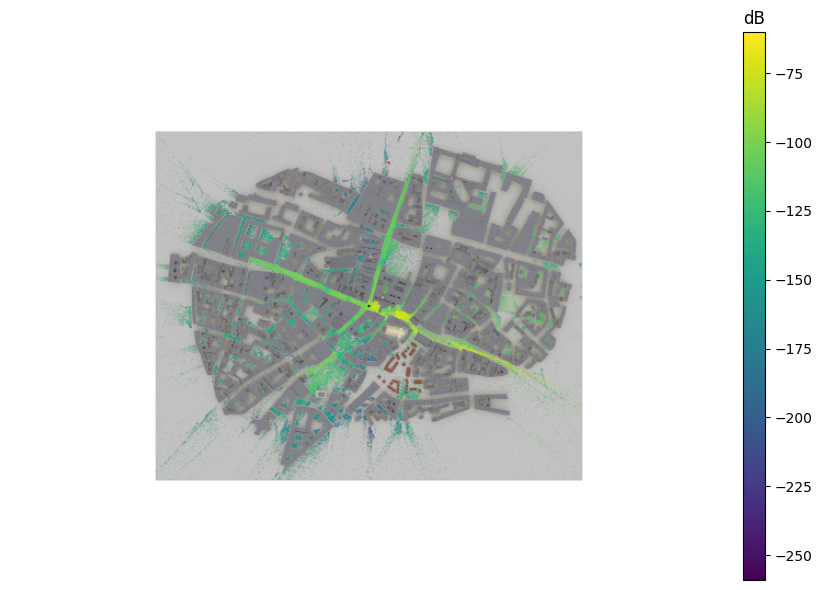

In [27]:
# test_pos = cell_centers[920,940]
test_pos = cell_centers[1098,  806]
scene.remove("test")
rx = Receiver(name=f"test",position=test_pos,color=[1,0,0])
scene.add(rx)
scene.render("birds_view", coverage_map=cm, num_samples=256);

In [14]:
scene.remove("tx")
tx = Transmitter(name="tx",
              position=[center[0],center[1],30],
              orientation=[0,0,0],
                color=(0,0,0))
scene.add(tx)

In [ ]:
dens_poses = [
            (380,550),
            (380,565),
            (380,580),
            (380,595),
            (380,610),
            (360,550),
            (360,565),
            (360,580),
            (360,595),
            (360,610),
        ]

for i in range(len(dens_poses)):
    rx = Receiver(name=f"rx-{i}-dens",
                  position=cm.cell_centers[dens_poses[i]],  # Random position sampled from coverage map
                  color=[1, 0, 0])
    scene.add(rx)

In [ ]:
cell_centers[360,580]

In [ ]:
scene.render("birds_view", coverage_map=cm, num_samples=256);

In [ ]:
cm_db = 10. * log10(cm._value[0])
tf.gather_nd(cm_db, dens_poses)

In [ ]:
dens_poses = [
            (880,800),
            (750,810),
            (760,820),
            (770,830),
            (780,840),
            (740,850),
            (750,860),
            (760,870),
            (770,880),
            (750,840)
        ]

for i in range(len(dens_poses)):
    rx = Receiver(name=f"rx-{i}-dens",
                  position=cm.cell_centers[dens_poses[i]],  # Random position sampled from coverage map
                  color=[1, 0, 0])
    scene.add(rx)

In [ ]:
scene.render("birds_view", coverage_map=cm, num_samples=256);

In [ ]:
dens_poses = [
            (740,800),
            (750,810),
            (760,820),
            (770,830),
            (780,840),
            (740,850),
            (750,860),
            (760,870),
            (770,880),
            (750,840)
        ]

for i in range(len(dens_poses)):
    rx = Receiver(name=f"rx-{i}-dens",
                  position=cm.cell_centers[dens_poses[i]],  # Random position sampled from coverage map
                  color=[1, 0, 0])
    scene.add(rx)

In [ ]:
scene.render("birds_view", coverage_map=cm, num_samples=256);

In [ ]:
min_gain_db = -130 # in dB; ignore any position with less than -130 dB path gain
max_gain_db = 0 # in dB; ignore strong paths

# sample points in a 5-400m radius around the receiver
min_dist = 5 # in m
max_dist = 400 # in m

#sample batch_size random user positions from coverage map
ue_pos = cm.sample_positions(batch_size=16,
                             min_gain_db=min_gain_db,
                             max_gain_db=max_gain_db,
                             min_dist=min_dist,
                             max_dist=max_dist,
                             center_pos = True)

In [ ]:
# Remove old receivers from scene
scene.remove("rx")
for i in range(16):
    scene.remove(f"rx-{i}")

# Configure antenna array for all receivers (=UEs)
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=int(4), # Each receiver is equipped with 4 tx antennas (uplink)
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso", # UE orientation is random
                             polarization="cross")

# Create batch_size receivers
for i in range(16):
    rx = Receiver(name=f"rx-{i}",
                  position=ue_pos[i], # Random position sampled from coverage map
                  )
    scene.add(rx)

# And visualize the scene

scene.render("birds_view", show_devices=True, resolution=[1000,1000]);

scene.preview(show_devices=True, coverage_map=cm)

In [ ]:
cm_db = 10.*log10(cm._value[0, :, :])

In [ ]:
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)

In [ ]:
scene.preview(paths=paths) # Open preview showing paths

In [ ]:
# Default parameters in the PUSCHConfig
subcarrier_spacing = 15e3
fft_size = 48

In [ ]:
# Print shape of channel coefficients before the application of Doppler shifts
# The last dimension corresponds to the number of time steps which defaults to one
# as there is no mobility
#print("Shape of `a` before applying Doppler shifts: ", paths.a.shape)

# Apply Doppler shifts
paths.apply_doppler(sampling_frequency=subcarrier_spacing, # Set to 15e3 Hz
                    num_time_steps=14, # Number of OFDM symbols
                    tx_velocities=[3.,0,0], # We can set additional tx speeds
                    rx_velocities=[0,7.,0]) # Or rx speeds

print("Shape of `a` after applying Doppler shifts: ", paths.a.shape)

a, tau = paths.cir()
print("Shape of tau: ", tau.shape)

In [ ]:
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");


In [ ]:
# Disable normalization of delays
paths.normalize_delays = False

# Get only the LoS path
_, tau = paths.cir(los=True, reflection=False)
print("Delay of first path without normalization: ", np.squeeze(tau))

paths.normalize_delays = True
_, tau = paths.cir(los=True, reflection=False)
print("Delay of first path with normalization: ", np.squeeze(tau))



In [ ]:
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)

# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=True) # Non-normalized includes path-loss

# Verify that the channel power is normalized
h_avg_power = tf.reduce_mean(tf.abs(h_freq)**2).numpy()

print("Shape of h_freq: ", h_freq.shape)
print("Average power h_freq: ", h_avg_power) # Channel is normalized

In [ ]:
# Placeholder for tx signal of shape
# [batch size, num_tx, num_tx_ant, num_ofdm_symbols, fft_size]
x = tf.zeros([h_freq.shape.as_list()[i] for i in [0,3,4,5,6]], tf.complex64)

no = 0.1 # noise variance

# Init channel layer
channel = ApplyOFDMChannel(add_awgn=True)

# Apply channel
y = channel([x, h_freq, no])

# [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size]
print(y.shape)

In [ ]:
# Init pusch_transmitter
pusch_config = PUSCHConfig()

# Instantiate a PUSCHTransmitter from the PUSCHConfig
pusch_transmitter = PUSCHTransmitter(pusch_config)

# Create a PUSCHReceiver using the PUSCHTransmitter
pusch_receiver = PUSCHReceiver(pusch_transmitter)

In [ ]:
# Simulate transmissions over the
batch_size = 100 # h_freq is broadcast, i.e., same CIR for all samples but different AWGN realizations
ebno_db = 2. # SNR in dB

no = ebnodb2no(ebno_db,
               pusch_transmitter._num_bits_per_symbol,
               pusch_transmitter._target_coderate,
               pusch_transmitter.resource_grid)

x, b = pusch_transmitter(batch_size) # Generate transmit signal and info bits

y = channel([x, h_freq, no]) # Simulate channel output

b_hat = pusch_receiver([y, no]) # Recover the info bits

# Compute BER
print(f"BER: {compute_ber(b, b_hat).numpy():.5f}")

